In [37]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
import scipy.stats as sps
from random import choices
import time
from numpy.random import RandomState
import pandas as pd
from scipy.stats import cauchy, gamma, norm, dirichlet, expon, uniform, invgauss, mode 
from scipy.stats import beta as beta_dist

In [38]:
def genParam(n, randomstate) :
    r = np.random.RandomState(seed=randomstate)
    
    alpha = r.exponential(1,(n,3))
    ksi = np.abs(r.standard_cauchy(2))
    beta = [r.dirichlet(alpha[0])]
    for i in range(1,n) :
      betai = [r.dirichlet(alpha[i])]
      beta = np.concatenate((beta,betai), axis=0)
    
    mu = [[beta[0][0]-beta[0][1], 2*(beta[0][0]+beta[0][1])-1]]
    for i in range(1,n) :
      mui = [[beta[i][0]-beta[i][1], 2*(beta[i][0]+beta[i][1])-1]]
      mu = np.concatenate((mu, mui),axis=0)
    sigma = r.wald(ksi[0], ksi[1],n)
    
    return(alpha, ksi, beta, mu, sigma)

In [39]:
def genX(n, T, mu, sigma) :
    A = np.eye(T, T+2) + mu[0][0]*np.eye(T, T+2,1) + mu[0][1]*np.eye(T, T+2,2)
    A = A@A.T
    X = [np.random.multivariate_normal(np.zeros(T), sigma[0]*A)]
    for i in range(1,n) :
      A = np.eye(T, T+2) + mu[i][0]*np.eye(T, T+2,1) + mu[i][1]*np.eye(T, T+2,2)
      A = sigma[i]*A@A.T
      Xi = [np.random.multivariate_normal(np.zeros(T), A)]
      X = np.concatenate((X,Xi), axis=0)
    return(X)

Algorithme 1 : Gibbs-ABC

In [40]:
def prior(n, hyper):
    X_1 = beta_dist.rvs(hyper[0], hyper[1] + hyper[2], size=n)
    Temp = beta_dist.rvs(hyper[1], hyper[2], size=n)
    X_2 = Temp * (1 - X_1)
    R_1 = X_1 - X_2
    R_2 = 2 * (X_1 + X_2) - 1
    return np.column_stack((R_1, R_2))

def distautcor(Z, X):
    min_length = min(len(Z), len(X))
    Z = Z[:min_length]
    X = X[:min_length]
    
    p = len(Z)
    a2 = np.sum(Z[2:p] * Z[0:(p - 2)])
    b2 = np.sum(X[2:p] * X[0:(p - 2)])
    a1 = np.sum(Z[1:p] * Z[0:(p - 1)])
    b1 = np.sum(X[1:p] * X[0:(p - 1)])
    return np.sqrt((a2 - b2)**2 + (a1 - b1)**2)

In [41]:
def ABCbas(X, N, T, mu, sigma):
    distances = []
    for i in range(N):
        simulated_X = genX(1, T, [mu], [sigma])  
        simulated_X = np.array(simulated_X) 
        distance = distautcor(X.flatten(), simulated_X.flatten())
        distances.append((distance, mu, sigma))
    min_distance_index = np.argmin([d[0] for d in distances])
    distance_values = np.array([d[0] for d in distances])
    return distances[min_distance_index][1], distances[min_distance_index][2]

def statdir(U):
    q = (U[:, 1] + 2 * U[:, 0] + 1) / 4
    q = np.where(q != 0, q, np.finfo(float).eps)  # Eviter la division par 0
    return np.array([np.sum(np.log(q)), np.sum(np.log(np.abs(q - U[:, 0])))])

def ABChaut(Q1, Q2, L):
    Q = np.column_stack((Q1, Q2))
    hyper = expon.rvs(size=(L, 3))  
    dist = np.zeros(L)
    for i in range(L):
        U = prior(len(Q1), hyper[i]) 
        dist[i] = np.sum((statdir(U) - statdir(Q))**2)
    return hyper[np.argmin(dist)]

def ABCsigm(Dat, j, parh1, parh2, parsigm1, parsigm2, N, T):
    dist = np.zeros(N)
    w = np.arange(1, min(Dat.shape[0], 10))
    si = 1 / gamma.rvs(parsigm1, scale=parsigm2, size=N)
    for i in range(N):
        simulated_data = genX(1, T, np.array([[parh1[j], parh2[j]]]), np.array([si[i]]))
        simulated_data = np.array(simulated_data)
        if j >= Dat.shape[1]:
            raise IndexError(f"Index {j} is out of bounds for axis 1 with size {Dat.shape[1]}")
        valid_w = w[w < Dat.shape[0]] 
        if len(valid_w) == 0:
            raise ValueError("No valid indices in w for accessing Dat.")
        dist[i] = np.abs(np.var(simulated_data.flatten()[valid_w]) - np.var(Dat[valid_w, j]))
    return si[np.argmin(dist)]

def ABCsigmhaut(sigm, Q):
    dist = np.zeros(Q)
    pri = np.abs(cauchy.rvs(size=(Q, 2)))
    for i in range(Q):
        h = pri[i]
        y = 1 / gamma.rvs(h[0], scale=h[1], size=len(sigm))
        dist[i] = np.abs(np.sum(np.log(y)) - np.sum(np.log(sigm))) + np.abs(np.sum(y) - np.sum(sigm))
    return pri[np.argmin(dist)]

In [42]:
def GibbsABC(X, N, M, P, P2, Npts, objectifeps, temps_max, T, randomstate=0):
    n = X.shape[1]  # Nombre de trajectoires dans les données d'entrée
    alpha, ksi, beta, mu, sigma = genParam(n, randomstate)
    
    start_time = time.time()

    eps_estimate = float('inf')  
    facteur_decroissance = 0.99 

    results = {
        "Paramètres_mu": [],
        "Paramètres_sigma": [],
        "Hyperparamètres": [],
        "Hypersigma": [],
        "Histeps": [],  
        "Eps_final": None  
    }
    
    for iteration in range(Npts):
        current_time = time.time()
        if current_time - start_time > temps_max:
            print(f"Temps maximum d'exécution de {temps_max} secondes atteint à la {iteration}ème itération.")
            break

        mu_updates = []
        sigma_updates = []
        dist_i = [] 

        for j in range(n):
            mu_best, sigma_best = ABCbas(X[:, j], N, T, mu[j], sigma[j])
            mu[j] = mu_best
            sigma[j] = sigma_best
            mu_updates.append(mu_best)
            sigma_updates.append(sigma_best)
            simu_j = genX(1, T, [mu[j]], [sigma[j]])  
            # Calculer la distance en utilisant la variance
            dist = np.abs(np.var(simu_j) - np.var(X[:, j]))
            dist_i.append(dist)
        
        # Mettre à jour eps_estimate avec la distance maximale de cette itération si elle est plus petite
        eps_iteration = max(dist_i)
        eps_estimate = min(eps_estimate, eps_iteration) * facteur_decroissance
        # Vérifier si l'estimation d'epsilon dépasse l'objectif après toutes les mises à jour
        if eps_estimate > objectifeps:
            print(f"L'objectif epsilon de {objectifeps} a été dépassé avec une estimation de {eps_estimate}. Arrêt du programme.")
            break  # Sortir de la boucle principale si l'objectif epsilon est dépassé

        results["Histeps"].append(eps_estimate)  
        results["Eps_final"] = eps_estimate
        results["Paramètres_mu"].append(mu_updates)
        results["Paramètres_sigma"].append(sigma_updates)
        
        # Mettre à jour les hyperparamètres à l'aide d'ABChaut 
        Q1, Q2 = mu[:, 0], mu[:, 1]
        hyper_best = ABChaut(Q1, Q2, M)
        
        # Mettre à jour le sigma à l'aide d'ABCsigm pour chaque trajectoire
        for j in range(n):
            sigma_j = ABCsigm(X, j, mu[:, 0], mu[:, 1], hyper_best[0], hyper_best[1], P, T)
            sigma[j] = sigma_j
        
        # Mettre à jour l'hypersigma à l'aide d'ABCsigmhaut
        hypersigma_best = ABCsigmhaut(sigma, P2)
        
        results["Hyperparamètres"].append(hyper_best)
        results["Hypersigma"].append(hypersigma_best)

    return results

In [43]:
def GibbsABC(X, N, M, P, P2, Npts, objectifeps, temps_max, T, randomstate=0):
    n = X.shape[1]  # Nombre de trajectoires dans les données d'entrée
    alpha, ksi, beta, mu, sigma = genParam(n, randomstate)
    
    start_time = time.time()

    eps_estimate = float('inf')  
    facteur_decroissance = 0.99 

    results = {
        "Paramètres_mu": [],
        "Paramètres_sigma": [],
        "Hyperparamètres": [],
        "Hypersigma": [],
        "Histeps": [],  
        "Eps_final": None  
    }
    
    for iteration in range(Npts):
        current_time = time.time()
        if current_time - start_time > temps_max:
            print(f"Temps maximum d'exécution de {temps_max} secondes atteint à la {iteration}ème itération.")
            break

        # mu_updates = []  # Cette ligne est commentée car mu ne sera pas mis à jour
        sigma_updates = []
        dist_i = [] 

        for j in range(n):
            # mu_best, sigma_best = ABCbas(X[:, j], N, T, mu[j], sigma[j])  # mu_best n'est plus nécessaire
            sigma_best = ABCbas(X[:, j], N, T, mu[j], sigma[j])[1]  # On récupère seulement sigma_best
            # mu[j] = mu_best  # Cette ligne est commentée car mu ne sera pas mis à jour
            sigma[j] = sigma_best
            # mu_updates.append(mu_best)  # Cette ligne est commentée car mu ne sera pas mis à jour
            sigma_updates.append(sigma_best)
            simu_j = genX(1, T, [mu[j]], [sigma[j]])  
            # Calculer la distance en utilisant la variance
            dist = np.abs(np.var(simu_j) - np.var(X[:, j]))
            dist_i.append(dist)
        
        eps_iteration = max(dist_i)
        eps_estimate = min(eps_estimate, eps_iteration) * facteur_decroissance
        if eps_estimate > objectifeps:
            print(f"L'objectif epsilon de {objectifeps} a été dépassé avec une estimation de {eps_estimate}. Arrêt du programme.")
            break

        results["Histeps"].append(eps_estimate)  
        results["Eps_final"] = eps_estimate
        # results["Paramètres_mu"].append(mu_updates)  # Cette ligne est commentée car mu ne sera pas mis à jour
        results["Paramètres_sigma"].append(sigma_updates)
        
        Q1, Q2 = mu[:, 0], mu[:, 1]
        hyper_best = ABChaut(Q1, Q2, M)
        
        for j in range(n):
            sigma_j = ABCsigm(X, j, mu[:, 0], mu[:, 1], hyper_best[0], hyper_best[1], P, T)
            sigma[j] = sigma_j
        
        hypersigma_best = ABCsigmhaut(sigma, P2)
        
        results["Hyperparamètres"].append(hyper_best)
        results["Hypersigma"].append(hypersigma_best)

    return results

In [49]:
N = 30  # Nombre de simulations pour les paramètres
M = 30  # Nombre de simulations pour l'hyperparamètre
P = 30  # Nombre de simulations pour sigma
P2 = 30  # Nombre de simulations pour hypersigma
Npts = 1000 # Nombre total d'itérations de l'algorithme global

n = 2  #Nombre de trajectoires dans les données d'entrée
T = 40 # Longueur des trajectoires dans les données d'entrée

objectifeps = 8 # Seuil de niveau d'erreur entre les données simulées et les données observées
temps_max = 10  # Temps d'éxecution maximum de l'algorithme global en secondes

alpha, ksi, beta, mu, sigma=genParam(n, randomstate=0)
X=genX(n, T, mu, sigma)

hyper_real= [1,1,1]
hypersigm_real= ksi

In [45]:
resultats = GibbsABC(X, N, M, P, P2, Npts, objectifeps, temps_max, T)
resultats

C:\Users\sarah\AppData\Local\Temp\ipykernel_15928\949033940.py:15: RuntimeWarning: divide by zero encountered in log
  return np.array([np.sum(np.log(q)), np.sum(np.log(np.abs(q - U[:, 0])))])
C:\Users\sarah\AppData\Local\Temp\ipykernel_15928\3565452515.py:4: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  X = [np.random.multivariate_normal(np.zeros(T), sigma[0]*A)]
C:\Users\sarah\AppData\Local\Temp\ipykernel_15928\949033940.py:23: RuntimeWarning: invalid value encountered in subtract
  dist[i] = np.sum((statdir(U) - statdir(Q))**2)


Temps maximum d'exécution de 10 secondes atteint à la 7ème itération.


C:\Users\sarah\AppData\Local\Temp\ipykernel_15928\949033940.py:46: RuntimeWarning: divide by zero encountered in divide
  y = 1 / gamma.rvs(h[0], scale=h[1], size=len(sigm))


{'Paramètres_mu': [],
 'Paramètres_sigma': [[0.004691123263026888,
   0.0053685810625457514,
   0.006260961093463038,
   0.004901985601723259,
   0.004893692718171779,
   0.005348573192353696,
   0.0060089333403119324,
   0.005773195495225366,
   0.00507602074283653,
   0.005578690765388634,
   0.005804279704915846,
   0.005830258572196381,
   0.005794028532946113,
   0.006103920950474691,
   0.006639100706522165,
   0.00688432934062642,
   0.005634210741250379,
   0.005340612469483693,
   0.006686603141162015,
   0.005290946095746609,
   0.0050032438637526615,
   0.00746721279016238,
   0.005528649352318847,
   0.00680160128112345,
   0.00552680106436274,
   0.006457896133802036,
   0.006937650503688867,
   0.006244076989751558,
   0.005658814840120528,
   0.006179482677839679,
   0.006006580828980818,
   0.005297518215628718,
   0.007151829271878551,
   0.005378902935434269,
   0.005475925999041283,
   0.0055070330918703825,
   0.0063987591769808375,
   0.0066762187217214225,
   0.00

In [50]:
def distance(resultats, hyper_real, hypersigm_real):

    hyper_real=np.array(hyper_real)
    hypersigm_real=np.array(hypersigm_real)

    hyper_estime = resultats["Hyperparamètres"]
    hypersigm_estime = resultats["Hypersigma"]

    dist_eucli_hyper= np.sqrt(np.sum((hyper_estime - hyper_real) ** 2, axis=1))
    dist_eucli_hypersigm= np.sqrt(np.sum((hypersigm_estime - hypersigm_real) ** 2, axis=1))
    
    # Calculer les distances euclidiennes
    distance_hyper = np.mean(dist_eucli_hyper)
    distance_hypersigm = np.mean(dist_eucli_hypersigm)

    return {
        'Distance Hyperparamètre': distance_hyper,
        'Distance Hypersigma': distance_hypersigm
    }

In [51]:
temps_max_values = [10, 30]
standard_error_hyper = []
standard_error_hypersigma = []
distance_hyper = []
distance_hypersigm = []
epsilon=[]

for temps_max in temps_max_values:
    resultats = GibbsABC(X, N, M, P, P2, Npts, objectifeps, temps_max, T)
    hyper = resultats["Hyperparamètres"]
    hypersigma=resultats["Hypersigma"]
    std_hypersigma = np.std(hypersigma)
    standard_error_hypersigma.append(std_hypersigma)

    epsilon.append(resultats["Eps_final"]) 

    dist = distance(resultats, hyper_real, hypersigm_real)
    dist_hypersigm=dist['Distance Hypersigma']
    distance_hypersigm.append(dist_hypersigm)

C:\Users\sarah\AppData\Local\Temp\ipykernel_15928\949033940.py:15: RuntimeWarning: divide by zero encountered in log
  return np.array([np.sum(np.log(q)), np.sum(np.log(np.abs(q - U[:, 0])))])
C:\Users\sarah\AppData\Local\Temp\ipykernel_15928\949033940.py:23: RuntimeWarning: invalid value encountered in subtract
  dist[i] = np.sum((statdir(U) - statdir(Q))**2)
C:\Users\sarah\AppData\Local\Temp\ipykernel_15928\3565452515.py:4: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  X = [np.random.multivariate_normal(np.zeros(T), sigma[0]*A)]


Temps maximum d'exécution de 10 secondes atteint à la 7ème itération.


C:\Users\sarah\AppData\Local\Temp\ipykernel_15928\949033940.py:46: RuntimeWarning: divide by zero encountered in divide
  y = 1 / gamma.rvs(h[0], scale=h[1], size=len(sigm))
C:\Users\sarah\AppData\Local\Temp\ipykernel_15928\949033940.py:46: RuntimeWarning: overflow encountered in divide
  y = 1 / gamma.rvs(h[0], scale=h[1], size=len(sigm))


Temps maximum d'exécution de 30 secondes atteint à la 22ème itération.


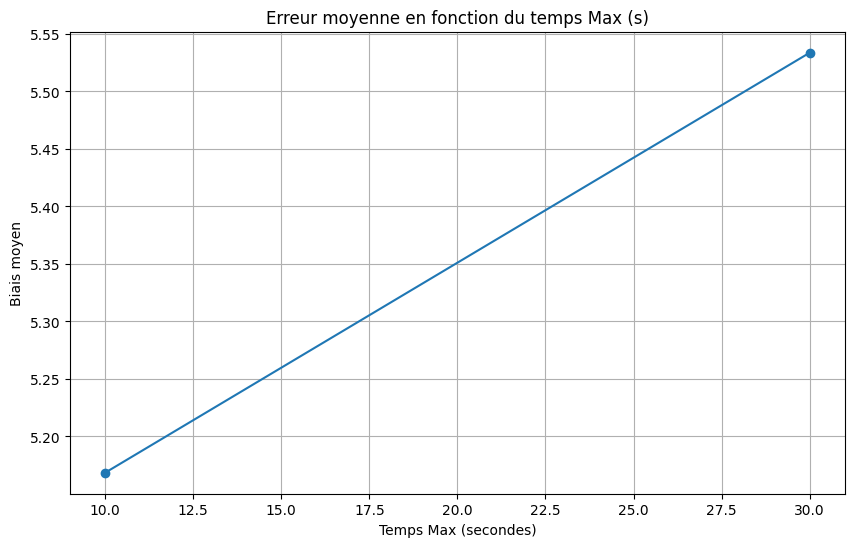

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(temps_max_values, distance_hypersigm , marker='o', linestyle='-')
plt.title('Erreur moyenne en fonction du temps Max (s)')
plt.xlabel('Temps Max (secondes)')
plt.ylabel('Biais moyen')
plt.grid(True)
plt.show()

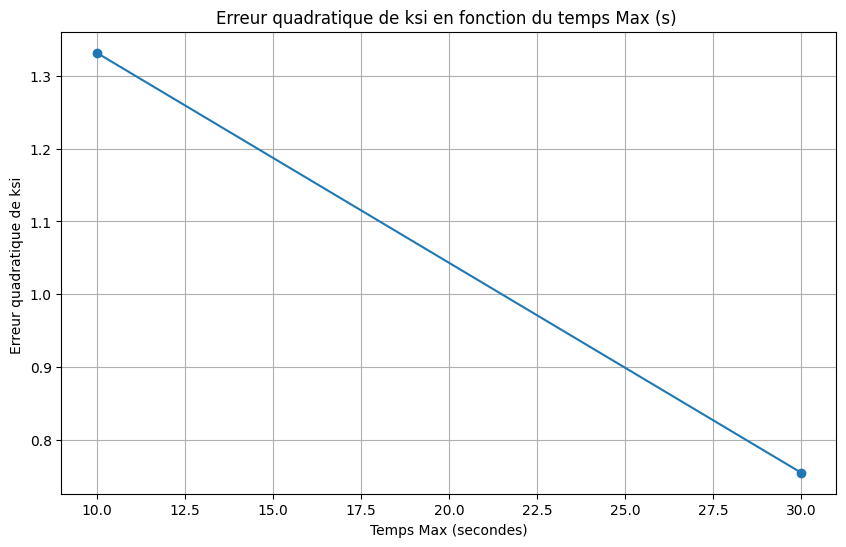

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(temps_max_values, standard_error_hypersigma, marker='o', linestyle='-')
plt.title('Erreur quadratique de ksi en fonction du temps Max (s) ')
plt.ylabel('Erreur quadratique de ksi ')
plt.xlabel('Temps Max (secondes)')
plt.grid(True)
plt.show()

In [ ]:
def changepoids(simui, nouveps, eps, T, M):
    if simui[0]==0:
        return(simui)
    if sum(simui[T+9:T+M+9]<= eps) == 0:
        simui[1] = 0
        return(simui)
    simui[1]=simui[0]*sum(simui[T+9:T+M+9]<= nouveps)/sum(simui[T+9:T+M+9]<= eps)
    return(simui)
    
def changementeps(simu, eps, alpha, n, M, T):
    epsilons = np.sort(simu[:,T+9:M+T+9][simu[:,T+9:M+T+9]<eps])[::-1]
    #print(epsilons)
    nbops = len(epsilons)
    print("nbops")
    print(nbops)
    no = nbops
    ESS = 1/sum(simu[:,0]**2)
    k = int((1-alpha)*ESS*no/n/2)
    while (k<nbops-1):
        nouveps = epsilons[k]
        a=True
        simu = np.apply_along_axis(lambda x : changepoids(x, nouveps, eps,T, M),1,simu)
        simu[:,1] = simu[:,1] / sum(simu[:,1])
        nouvESS = 1/sum(simu[:,1]**2)
        if nouvESS < (alpha * ESS) :
            simu[:,0] = simu[:,1]
            simu[:,1] = np.zeros(n)
            return(simu, nouveps, nouvESS)
        k += max(1,int((nouvESS-alpha*ESS)*(no-k)/n/2))
    return(simu,eps,ESS)

def chgtpar(simui, sdsigma, eps, dprior, dist, n, M, T):
    varsigma = np.random.multivariate_normal(np.zeros(l),cov=sdsigma)
    simu = np.abs(simui + np.concatenate((np.zeros(9),varsigma,np.zeros(M))))
    matcalc = simu[9:T+9]
    vwald = np.var(matcalc)
    ewald = np.mean(matcalc)
    ksi1 = ewald
    ksi2 = ewald**3/vwald
    simu[5:7] = np.array([ksi1, ksi2])
    #print(simu)
    simu[T+9:T+M+9] = dist(simu)
    snew = sum(simu[T+9:T+M+9] <= eps)
    sold = sum(simui[T+9:T+M+9] <= eps)
    u = np.random.uniform(1)
    if sold == 0:
        return(simui)
    if (u < (snew / sold * dprior(simu) / dprior(simui))):
        print("c")
        return(simu)
    else :
        return(simui)
        
np.set_printoptions(threshold=10000)
def smc(data, n, M, Npts, objectifeps, alpha, rprior, dprior, dist, T, tempsmax):
    start_time = time.time()
    simu = np.concatenate((np.zeros((n,2)),np.abs(rprior(n))), axis = 1)
    distances = np.apply_along_axis(dist,1,simu)
    simu = np.concatenate((simu,distances), axis = 1)
    j=1
    simu[:,0] = np.array([1/n]*n)
    ESS = n
    eps = np.max(simu[:,T+9:M+T+9])
    histeps = [eps]
    while ((j<maxiter) and (eps>objectifeps) and (time.time()-start_time < tempsmax)):
        (simu, eps, ESS) = changementeps(simu, eps, alpha, n, M, T)
        histeps.append(eps)
        if (ESS < n / 2) :
            simu = np.array(choices(simu, weights = simu[:,0], k = n))
            simu[:,0] = np.array([1/n]*n)
            ESS = n
            simu[:,T+9:M+T+9] = np.apply_along_axis(dist,1,simu)
        print(distances.shape)
        simumat = simu[:,9:T+9].reshape(n,T)
        sdsigma = 2 * np.cov(np.transpose(simumat))
        simu = np.apply_along_axis(lambda x : chgtpar(x, sdsigma, eps, dprior, dist, n, M, T),1,simu)
        print(j,eps)
        j += 1
    simu = np.array(choices(simu, weights = simu[:,0], k = n))
    #poids = np.array([1/n]*n)
    ESS = n
    distances = np.array([dist(i) for i in simu]*M)
    return(simu, histeps)

In [ ]:
M = 30
n = 50
randomstate = 0
T = 50

alpha, ksi, beta, mu, sigma = genParam(n, randomstate)
X = genX(n, T, mu, sigma)

print(np.shape(alpha))
print(np.shape(X))
print(mu)
print(sigma)

def gen(mu1,mu2,s,n):
    A = np.random.normal(0,max(s,0),n+2)
    return(A[2:(n + 2)] + mu1 * A[1:(n + 1)] + mu2 * A[0:n])

def rprior(n):
    alphas = alpha
    ksis = np.abs(np.random.standard_cauchy(size = (n,2)))
    mus = mu
    res2 = np.apply_along_axis(lambda x : np.random.wald(x[0], x[1], size = T),1,ksis)
    return(np.concatenate((alphas,ksis,mus,res2.reshape(n,-1)),axis=1))

statdata = np.apply_along_axis(lambda x : np.percentile(x, np.arange(10, 91, 10)),0,X)
        
def dprior(simui):
    ksi1 = simui[5]
    ksi2 = simui[6]
    matsim = np.expand_dims(simui[9:T+9], axis = 1)
    return(np.sum(np.apply_along_axis(lambda s : invgauss.pdf(s[0], mu = ksi1/ksi2, scale = ksi2), 1, matsim)))

def dist(simui):
    lev = np.arange(0.1, 0.91, 0.1)
    mu1 = simui[8]
    mu2 = simui[9]
    s = np.expand_dims(simui[9:T+9], axis=1)
    somme = np.apply_along_axis(lambda i : np.sum(np.abs(np.apply_along_axis(lambda x : np.percentile(gen(mu1, mu2, x[0], n), np.arange(10,91,10)),0,s)-statdata)),1,np.zeros((M,1)))
    return(somme)

In [ ]:
result10 = np.zeros((5,50,89))
temps = 10
for i in range(5):
    res, hist = smc(data, n, M, 60, 50, 0.9, rprior, dprior, dist, l, temps)
    result10[i] = res
result30 = np.zeros((5,50,89))
temps = 30
for i in range(5):
    res, hist = smc(data, n, M, 60, 50, 0.9, rprior, dprior, dist, l, temps)
    result30[i] = res
result60 = np.zeros((5,50,89))
temps = 60
for i in range(5):
    res, hist = smc(data, n, M, 60, 50, 0.9, rprior, dprior, dist, l, temps)
    result60[i] = res
result120 = np.zeros((5,50,89))
temps = 120
for i in range(5):
    res, hist = smc(data, n, M, 60, 50, 0.9, rprior, dprior, dist, l, temps)
    result120[i] = res

In [ ]:
print(np.sqrt((np.mean(result10[:,:,5])-ksi[0])**2+(np.mean(result10[:,:,6])-ksi[1])**2))
print(np.sqrt((np.mean(result30[:,:,5])-ksi[0])**2+(np.mean(result30[:,:,6])-ksi[1])**2))
print(np.sqrt((np.mean(result60[:,:,5])-ksi[0])**2+(np.mean(result60[:,:,6])-ksi[1])**2))
print(np.sqrt((np.mean(result120[:,:,5])-ksi[0])**2+(np.mean(result120[:,:,6])-ksi[1])**2))

In [ ]:
er10 = 7.656633918599754
er20 = 
er30 = 1.7658691389749934
er60 = 2.4653378601507896
er120 = 1.9933199598636118
tmax =[10,30,60,120]
erreurs = [er10,er30,er60,er120]

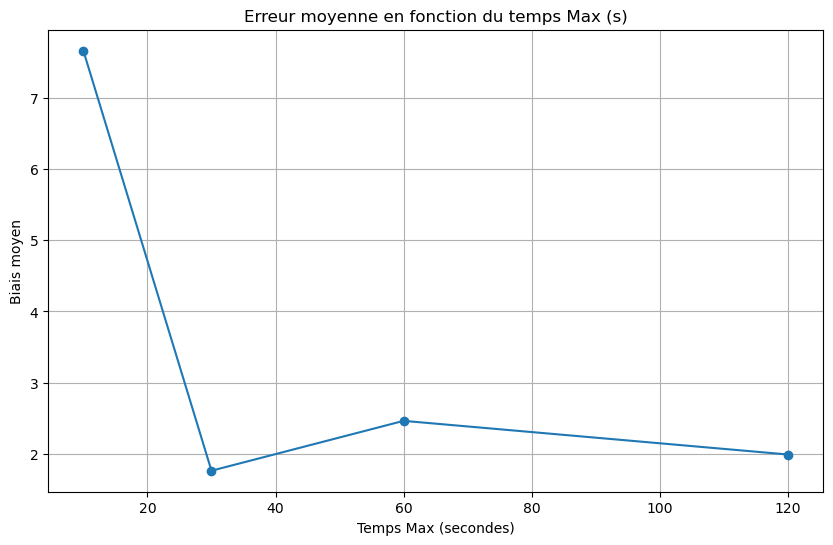

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(tmax, erreurs, marker='o', linestyle='-')
plt.title('Erreur moyenne en fonction du temps Max (s)')
plt.xlabel('Temps Max (secondes)')
plt.ylabel('Biais moyen')
plt.grid(True)
plt.show()

In [ ]:
erq10 = 7.656633918599754
erq30 = 1.7658691389749934
erq60 = 2.4653378601507896
erq120 = 1.9933199598636118
tmax =[10,30,60,120]
erreurs = [er10,er30,er60,er120]

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(tmax, erreurs, marker='o', linestyle='-')
plt.title('Erreur moyenne en fonction du temps Max (s)')
plt.xlabel('Temps Max (secondes)')
plt.ylabel('Biais moyen')
plt.grid(True)
plt.show()

In [ ]:
def MH(N, n, T, randomstate) :
    
    time0 = time.time()
    
    #Génération des données observées
    alpha, ksi, beta, mu, sigma = genParam(n, randomstate)
    X = genX(n, T, mu, sigma)
    
    #Génération de l'état initial
    ksiMH = [np.abs(np.random.standard_cauchy(2))]
    sigmaMH = [np.random.wald(ksiMH[0][0], ksiMH[0][1], n)]
    
    #Génération de la chaîne de Markov
    for i in range(N) :
        L = 1
    
        #Génération des propositions
        ksiMHprop = [np.random.exponential(scale=ksiMH[i][0]), np.random.exponential(scale=ksiMH[i][1])]
        sigmaMHprop = []
        for k in range(n) :
            sigmaMHprop.append(np.random.exponential(scale=sigmaMH[i][k]))
        Lprop = 1
        
        for j in range(n):
    
            AMH = np.eye(T, T+2) + mu[j][0]*np.eye(T, T+2,1) + mu[j][1]*np.eye(T, T+2,2)
            AMH = sigmaMH[i][j]*(AMH@AMH.T)
    
            L = L*scipy.stats.multivariate_normal.pdf(X[j], mean=np.zeros(T), cov=AMH)
            L = L*scipy.stats.invgauss.pdf(sigmaMH[i][j], mu=ksiMH[i][0]/ksiMH[i][1], loc=0, scale=ksiMH[i][1])
    
            AMHprop = np.eye(T, T+2) + mu[j][0]*np.eye(T, T+2,1) + mu[j][1]*np.eye(T, T+2,2)
            AMHprop = sigmaMHprop[j]*(AMHprop@AMHprop.T)
                
            Lprop = Lprop*scipy.stats.multivariate_normal.pdf(X[j], mean=np.zeros(T), cov=AMHprop)
            Lprop = Lprop*scipy.stats.invgauss.pdf(sigmaMHprop[j], mu=ksiMHprop[0]/ksiMHprop[1], loc=0, scale=ksiMHprop[1])
    
        L = L*scipy.stats.halfcauchy.pdf(ksiMH[i][0])*scipy.stats.halfcauchy.pdf(ksiMH[i][1])
        Lprop = Lprop*scipy.stats.halfcauchy.pdf(ksiMHprop[0])*scipy.stats.halfcauchy.pdf(ksiMHprop[1])
    
        num = 1
        den = 1
        for k in range(n) :
            num = num*scipy.stats.expon.pdf(sigmaMH[i][k], scale=sigmaMHprop[k])
            den = den*scipy.stats.expon.pdf(sigmaMHprop[k], scale=sigmaMH[i][k])
        num = num*scipy.stats.expon.pdf(ksiMH[i][0], scale=ksiMHprop[0])*scipy.stats.expon.pdf(ksiMH[i][1], scale=ksiMHprop[1])
        den = den*(scipy.stats.expon.pdf(ksiMHprop[0], scale=ksiMH[i][0])*scipy.stats.expon.pdf(ksiMHprop[1], scale=ksiMH[i][1]))
        num = num*Lprop
        den = den*L
        if den == 0 :  
            ksiMH = np.concatenate((ksiMH,[ksiMH[i]]), axis=0)
            sigmaMH = np.concatenate((sigmaMH, [sigmaMH[i]]), axis=0)
            #ksiMH = np.concatenate((ksiMH,[ksiMHprop]), axis=0)
            #sigmaMH = np.concatenate((sigmaMH, [sigmaMHprop]), axis=0)
        else :
            r = min(1, num/den)
            if np.random.uniform() <= r:
                ksiMH = np.concatenate((ksiMH,[ksiMHprop]), axis=0)
                sigmaMH = np.concatenate((sigmaMH, [sigmaMHprop]), axis=0)
            else : 
                ksiMH = np.concatenate((ksiMH,[ksiMH[i]]), axis=0)
                sigmaMH = np.concatenate((sigmaMH, [sigmaMH[i]]), axis=0)
    
    meanksiMH = [np.mean(ksiMH[:, 0]), np.mean(ksiMH[:, 1])]
    meansigmaMH = []
    for i in range(n) :
        meansigmaMH.append(np.mean(sigmaMH[:, i]))
            
    time1 = time.time()   
    return(sigmaMH[-1], meansigmaMH, ksiMH[-1], meanksiMH, time1-time0)